In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
# Get underlying prices
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [3]:
# Get the working dataframe
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [4]:
target = pd.read_csv("../data/processed/target_df.csv", index_col=0)["target"]

In [5]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

## Baseline logistic regression without new data

In [6]:
orig_df = ml_df[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_VOLUME",
        "diff_date",
    ]
].copy()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df.values, target.values.flatten(), test_size=0.2, random_state=1968
)

In [8]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        ("lg", LogisticRegression()),
    ]
)

In [9]:
print(
    f"A random guess would be correct {np.array(target).sum()/len(target):.2%} of times"
)

A random guess would be correct 48.28% of times


In [10]:
pipe.fit(X_train, y_train).score(X_test, y_test)

0.5418326693227091

In [11]:
predictions = pipe.predict(X_test)

In [12]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.53      0.62      0.57       123
           1       0.56      0.47      0.51       128

    accuracy                           0.54       251
   macro avg       0.54      0.54      0.54       251
weighted avg       0.54      0.54      0.54       251



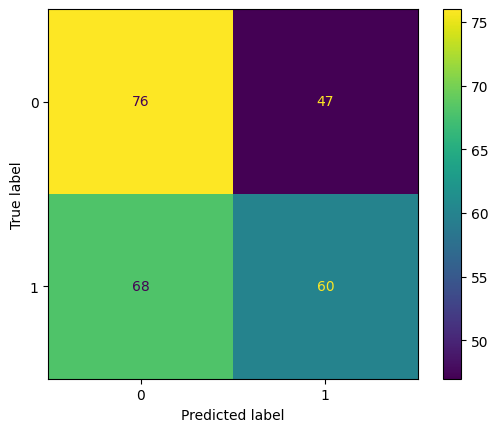

In [13]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

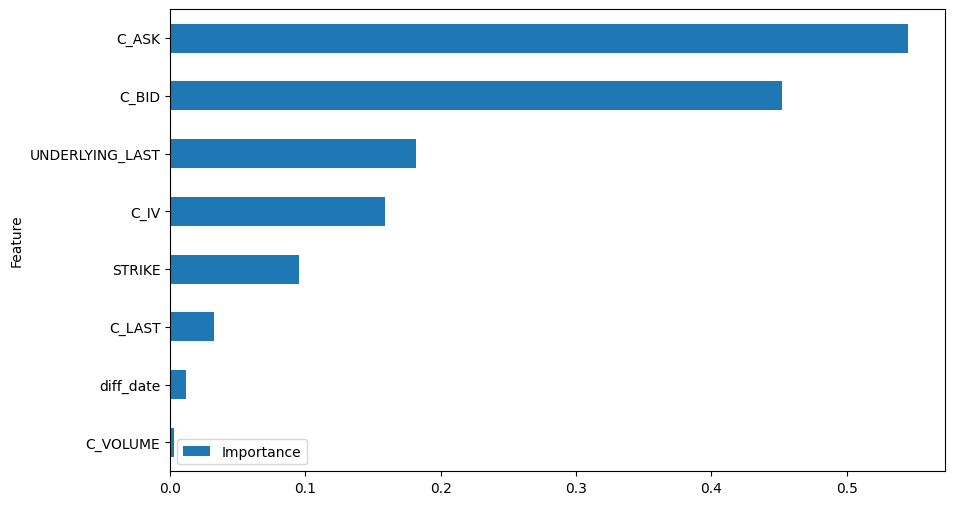

In [14]:
coefficients = pipe.named_steps["lg"].coef_[0]

feature_importance = pd.DataFrame(
    {"Feature": orig_df.columns, "Importance": np.abs(coefficients)}
)
feature_importance = feature_importance.sort_values("Importance", ascending=True)
feature_importance.plot(x="Feature", y="Importance", kind="barh", figsize=(10, 6))

## Logistic regression with data from MC simulation

In [15]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike"], axis=1),
    ),
    axis=1,
)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df.values, target.values.flatten(), test_size=0.2, random_state=1968
)

In [17]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        ("lg", LogisticRegression()),
    ]
)

In [18]:
pipe.fit(X_train, y_train).score(X_test, y_test)

0.5936254980079682

In [19]:
predictions = pipe.predict(X_test)

In [20]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.56      0.75      0.64       123
           1       0.65      0.45      0.53       128

    accuracy                           0.59       251
   macro avg       0.61      0.60      0.59       251
weighted avg       0.61      0.59      0.58       251



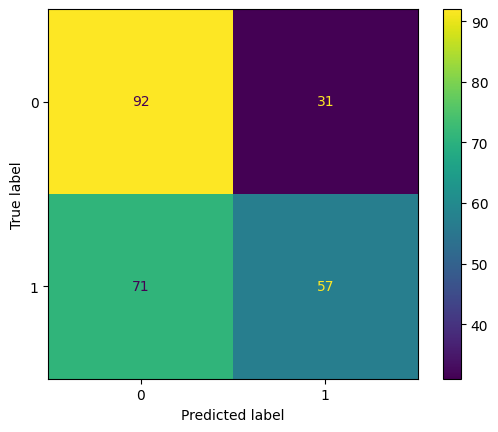

In [21]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

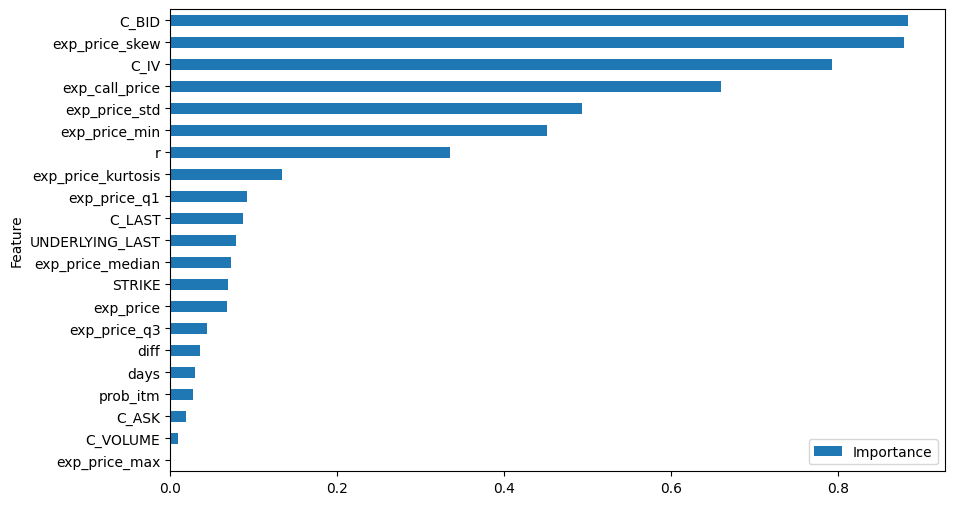

In [22]:
coefficients = pipe.named_steps["lg"].coef_[0]

feature_importance = pd.DataFrame(
    {"Feature": new_df.columns, "Importance": np.abs(coefficients)}
)
feature_importance = feature_importance.sort_values("Importance", ascending=True)
feature_importance.plot(x="Feature", y="Importance", kind="barh", figsize=(10, 6))

## Logistic regression with data from MC simulation and some addtional features

In [23]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike"], axis=1),
    ),
    axis=1,
)

In [24]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df.values, target.values.flatten(), test_size=0.2, random_state=1968
)

In [26]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        ("lg", LogisticRegression()),
    ]
)

In [27]:
pipe.fit(X_train, y_train).score(X_test, y_test)

0.5776892430278885

In [28]:
predictions = pipe.predict(X_test)

In [29]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.55      0.76      0.64       123
           1       0.63      0.41      0.50       128

    accuracy                           0.58       251
   macro avg       0.59      0.58      0.57       251
weighted avg       0.59      0.58      0.56       251



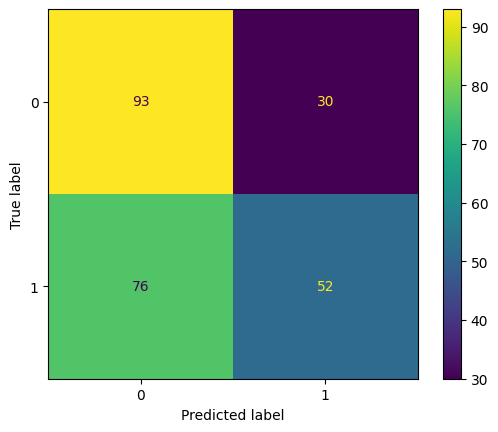

In [30]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

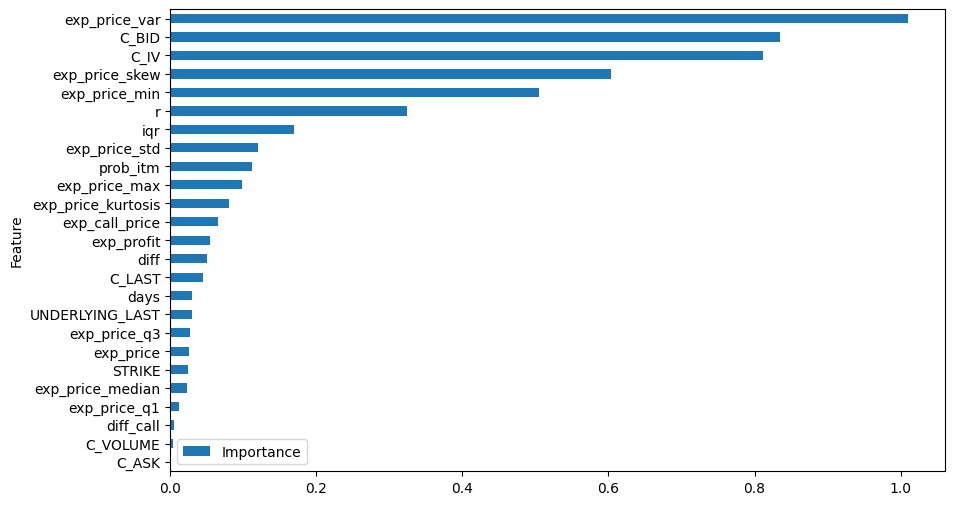

In [31]:
coefficients = pipe.named_steps["lg"].coef_[0]

feature_importance = pd.DataFrame(
    {"Feature": new_df.columns, "Importance": np.abs(coefficients)}
)
feature_importance = feature_importance.sort_values("Importance", ascending=True)
feature_importance.plot(x="Feature", y="Importance", kind="barh", figsize=(10, 6))

### Gridsearch Cross Validation

In [113]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike"], axis=1),
    ),
    axis=1,
)

In [114]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

In [115]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df.values, target.values.flatten(), test_size=0.2, random_state=1968
)

In [116]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        ("lg", LogisticRegression()),
    ]
)

In [117]:
# Penalties
penalty1 = ["l2"]
penalty2 = ["l1", "l2"]
penalty3 = ["l1", "l2", "elasticnet"]
# Number of features to consider at every split
C = np.logspace(-2, 2, 30)
# Solver
solver1 = ["lbfgs", "newton-cg", "newton-cholesky", "sag"]
solver2 = ["liblinear"]
solver3 = ["saga"]

# Create the search grid
param_grid = [
    {
        "lg__penalty": penalty1,
        "lg__C": C,
        "lg__solver": solver1,
        "lg__random_state": [1968],
        "lg__max_iter": [1000],
    },
    {
        "lg__penalty": penalty2,
        "lg__C": C,
        "lg__solver": solver2,
        "lg__random_state": [1968],
    },
    {
        "lg__penalty": penalty3,
        "lg__C": C,
        "lg__solver": solver3,
        "lg__random_state": [1968],
    },
]

In [118]:
verbose_level = 1
n_jobs = 4

In [119]:
# Grid search
lg_grid = GridSearchCV(
    estimator=pipe, param_grid=param_grid, cv=5, verbose=verbose_level, n_jobs=n_jobs
)

In [120]:
# Fit the search model
lg_grid.fit(X_train, y_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


/Users/andrea/Desktop/WQU-Course/MScFE/Capstone/wqu_capstone/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrea/Desktop/WQU-Course/MScFE/Capstone/wqu_capstone/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrea/Desktop/WQU-Course/MScFE/Capstone/wqu_capstone/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrea/Desktop/WQU-Course/MScFE/Capstone/wqu_capstone/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrea/Desktop/WQU-Course/MScFE/Capstone/wqu_capstone/.venv/lib/pytho

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(fill_value=0.0,
                                                      strategy='constant')),
                                       ('scaler', StandardScaler()),
                                       ('lg', LogisticRegression())]),
             n_jobs=4,
             param_grid=[{'lg__C': array([1.00000000e-02, 1.37382380e-02, 1.88739182e-02, 2.59294380e-02,
       3.56224789e-02, 4.89390092e-02, 6.72335754e-02, 9.23670857e-02,
       1.26896100e-01, 1.74332882e-01...
       4.52035366e-01, 6.21016942e-01, 8.53167852e-01, 1.17210230e+00,
       1.61026203e+00, 2.21221629e+00, 3.03919538e+00, 4.17531894e+00,
       5.73615251e+00, 7.88046282e+00, 1.08263673e+01, 1.48735211e+01,
       2.04335972e+01, 2.80721620e+01, 3.85662042e+01, 5.29831691e+01,
       7.27895384e+01, 1.00000000e+02]),
                          'lg__penalty': ['l1', 'l2', 'elasticnet'],
                          'lg__random_state': [1968], 'lg__solver': ['saga']}],
             verbose=1)

In [121]:
lg_grid.best_params_

{'lg__C': 0.6210169418915616,
 'lg__max_iter': 1000,
 'lg__penalty': 'l2',
 'lg__random_state': 1968,
 'lg__solver': 'lbfgs'}

In [122]:
pd.DataFrame.from_dict(lg_grid.cv_results_).sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lg__C,param_lg__max_iter,param_lg__penalty,param_lg__random_state,param_lg__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
54,0.005033,0.000246,0.001170,0.000086,0.621017,1000,l2,1968,newton-cholesky,"{'lg__C': 0.6210169418915616, 'lg__max_iter': ...",0.577114,0.577114,0.600,0.54,0.550,0.568846,0.021422,1
147,0.007571,0.000498,0.001925,0.001397,0.621017,NaN,l2,1968,liblinear,"{'lg__C': 0.6210169418915616, 'lg__penalty': '...",0.577114,0.577114,0.600,0.54,0.550,0.568846,0.021422,1
52,0.025274,0.010122,0.001994,0.001633,0.621017,1000,l2,1968,lbfgs,"{'lg__C': 0.6210169418915616, 'lg__max_iter': ...",0.577114,0.577114,0.600,0.54,0.550,0.568846,0.021422,1
53,0.020924,0.003356,0.001444,0.000289,0.621017,1000,l2,1968,newton-cg,"{'lg__C': 0.6210169418915616, 'lg__max_iter': ...",0.577114,0.577114,0.600,0.54,0.550,0.568846,0.021422,1
151,0.008258,0.001746,0.001080,0.000185,1.172102,NaN,l2,1968,liblinear,"{'lg__C': 1.1721022975334805, 'lg__penalty': '...",0.587065,0.567164,0.615,0.54,0.535,0.568846,0.029808,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,0.003417,0.001729,0.000000,0.000000,5.736153,NaN,elasticnet,1968,saga,"{'lg__C': 5.736152510448681, 'lg__penalty': 'e...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,241
191,0.002467,0.000841,0.000000,0.000000,0.025929,NaN,elasticnet,1968,saga,"{'lg__C': 0.02592943797404667, 'lg__penalty': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,241
221,0.003010,0.000681,0.000000,0.000000,0.621017,NaN,elasticnet,1968,saga,"{'lg__C': 0.6210169418915616, 'lg__penalty': '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,241
248,0.002484,0.000531,0.000000,0.000000,10.826367,NaN,elasticnet,1968,saga,"{'lg__C': 10.82636733874054, 'lg__penalty': 'e...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,241


In [123]:
best_model = lg_grid.best_estimator_

In [124]:
best_model.score(X_test, y_test)

0.5856573705179283

In [125]:
predictions = best_model.predict(X_test)

In [126]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.56      0.76      0.64       123
           1       0.65      0.41      0.50       128

    accuracy                           0.59       251
   macro avg       0.60      0.59      0.57       251
weighted avg       0.60      0.59      0.57       251



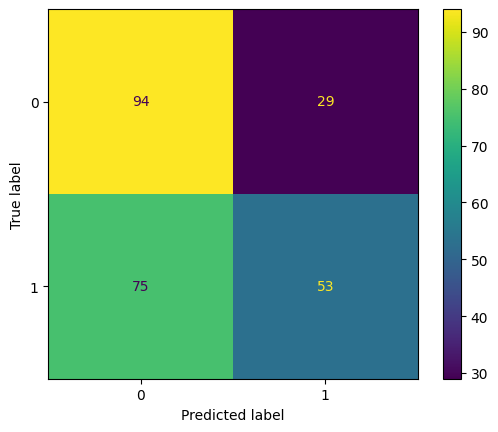

In [127]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

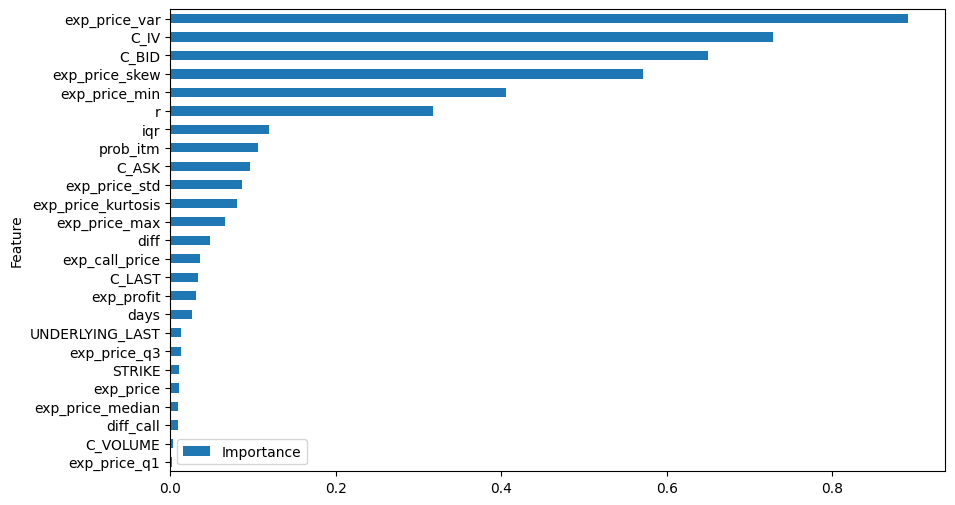

In [128]:
coefficients = best_model.named_steps["lg"].coef_[0]

feature_importance = pd.DataFrame(
    {"Feature": new_df.columns, "Importance": np.abs(coefficients)}
)
feature_importance = feature_importance.sort_values("Importance", ascending=True)
feature_importance.plot(x="Feature", y="Importance", kind="barh", figsize=(10, 6))

### Try feature selection

In [129]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [130]:
cv = StratifiedKFold(5)
clf = LogisticRegression()

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=1,
    n_jobs=2,
)

In [131]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        ("rfecv", rfecv),
    ]
)

In [132]:
pipe.fit(X_train, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 9


In [133]:
selected_features = new_df.columns[rfecv.support_]

In [134]:
rfecv.ranking_

array([ 4, 11, 10,  1, 17,  1, 16,  8,  9,  1,  1,  2,  1, 13, 14,  7,  5,
        1, 12,  1,  3,  1, 15,  1,  6])

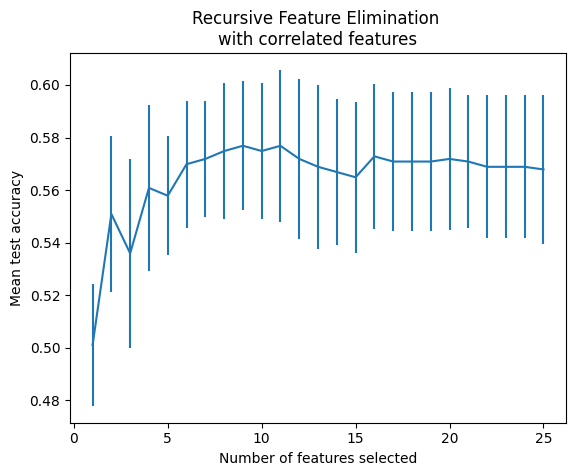

In [135]:
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

### Gridsearch Cross Validation with selected features

In [152]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike"], axis=1),
    ),
    axis=1,
)

In [137]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

In [138]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df[selected_features].values,
    target.values.flatten(),
    test_size=0.2,
    random_state=1968,
)

In [139]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        ("lg", LogisticRegression()),
    ]
)

In [140]:
# Penalties
penalty1 = ["l2"]
penalty2 = ["l1", "l2"]
# Number of features to consider at every split
C = np.logspace(-3, 3, 30)
# Solver
solver1 = ["lbfgs", "newton-cg", "newton-cholesky", "sag"]
solver2 = ["liblinear", "saga"]

# Create the search grid
param_grid = [
    {
        "lg__penalty": penalty1,
        "lg__C": C,
        "lg__solver": solver1,
        "lg__random_state": [1968],
        "lg__max_iter": [1000],
    },
    {
        "lg__penalty": penalty2,
        "lg__C": C,
        "lg__solver": solver2,
        "lg__random_state": [1968],
    },
]

In [141]:
verbose_level = 1
n_jobs = 4

In [142]:
# Grid search
lg_grid = GridSearchCV(
    estimator=pipe, param_grid=param_grid, cv=5, verbose=verbose_level, n_jobs=n_jobs
)

In [143]:
# Fit the search model
lg_grid.fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


/Users/andrea/Desktop/WQU-Course/MScFE/Capstone/wqu_capstone/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrea/Desktop/WQU-Course/MScFE/Capstone/wqu_capstone/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrea/Desktop/WQU-Course/MScFE/Capstone/wqu_capstone/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrea/Desktop/WQU-Course/MScFE/Capstone/wqu_capstone/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrea/Desktop/WQU-Course/MScFE/Capstone/wqu_capstone/.venv/lib/pytho

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(fill_value=0.0,
                                                      strategy='constant')),
                                       ('scaler', StandardScaler()),
                                       ('lg', LogisticRegression())]),
             n_jobs=4,
             param_grid=[{'lg__C': array([1.00000000e-03, 1.61026203e-03, 2.59294380e-03, 4.17531894e-03,
       6.72335754e-03, 1.08263673e-02, 1.74332882e-02, 2.80721620e-02,
       4.52035366e-02, 7.27895384e-02...
       3.03919538e-01, 4.89390092e-01, 7.88046282e-01, 1.26896100e+00,
       2.04335972e+00, 3.29034456e+00, 5.29831691e+00, 8.53167852e+00,
       1.37382380e+01, 2.21221629e+01, 3.56224789e+01, 5.73615251e+01,
       9.23670857e+01, 1.48735211e+02, 2.39502662e+02, 3.85662042e+02,
       6.21016942e+02, 1.00000000e+03]),
                          'lg__penalty': ['l1', 'l2'],
                          'lg__random_state': [1968],
                          'lg__solver': ['liblinear', 'saga']}],
             verbose=1)

In [144]:
lg_grid.best_params_

{'lg__C': 1000.0,
 'lg__max_iter': 1000,
 'lg__penalty': 'l2',
 'lg__random_state': 1968,
 'lg__solver': 'lbfgs'}

In [145]:
pd.DataFrame.from_dict(lg_grid.cv_results_).sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lg__C,param_lg__max_iter,param_lg__penalty,param_lg__random_state,param_lg__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
117,0.017449,0.004941,0.001568,0.000537,1000.0,1000,l2,1968,newton-cg,"{'lg__C': 1000.0, 'lg__max_iter': 1000, 'lg__p...",0.582090,0.557214,0.610,0.555,0.575,0.575861,0.019939,1
238,0.007828,0.001243,0.001829,0.000617,1000.0,NaN,l2,1968,liblinear,"{'lg__C': 1000.0, 'lg__penalty': 'l2', 'lg__ra...",0.582090,0.557214,0.610,0.555,0.575,0.575861,0.019939,1
116,0.023854,0.006028,0.000971,0.000189,1000.0,1000,l2,1968,lbfgs,"{'lg__C': 1000.0, 'lg__max_iter': 1000, 'lg__p...",0.582090,0.557214,0.610,0.555,0.575,0.575861,0.019939,1
118,0.005795,0.002193,0.001284,0.000532,1000.0,1000,l2,1968,newton-cholesky,"{'lg__C': 1000.0, 'lg__max_iter': 1000, 'lg__p...",0.582090,0.557214,0.610,0.555,0.575,0.575861,0.019939,1
56,0.011823,0.002425,0.001021,0.000152,0.788046,1000,l2,1968,lbfgs,"{'lg__C': 0.7880462815669912, 'lg__max_iter': ...",0.601990,0.557214,0.600,0.550,0.570,0.575841,0.021523,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,0.004541,0.002043,0.001057,0.000204,0.001,NaN,l1,1968,liblinear,"{'lg__C': 0.001, 'lg__penalty': 'l1', 'lg__ran...",0.522388,0.522388,0.525,0.525,0.525,0.523955,0.001280,229
133,0.004612,0.001282,0.001190,0.000248,0.004175,NaN,l1,1968,saga,"{'lg__C': 0.0041753189365604, 'lg__penalty': '...",0.477612,0.522388,0.525,0.525,0.525,0.515000,0.018721,237
129,0.002828,0.000690,0.000905,0.000223,0.002593,NaN,l1,1968,saga,"{'lg__C': 0.002592943797404667, 'lg__penalty':...",0.477612,0.522388,0.525,0.525,0.525,0.515000,0.018721,237
121,0.002933,0.000664,0.001105,0.000414,0.001,NaN,l1,1968,saga,"{'lg__C': 0.001, 'lg__penalty': 'l1', 'lg__ran...",0.477612,0.522388,0.525,0.525,0.525,0.515000,0.018721,237


In [146]:
best_model = lg_grid.best_estimator_

In [147]:
best_model.score(X_test, y_test)

0.5856573705179283

In [148]:
predictions = best_model.predict(X_test)

In [149]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.56      0.76      0.64       123
           1       0.65      0.41      0.50       128

    accuracy                           0.59       251
   macro avg       0.60      0.59      0.57       251
weighted avg       0.60      0.59      0.57       251



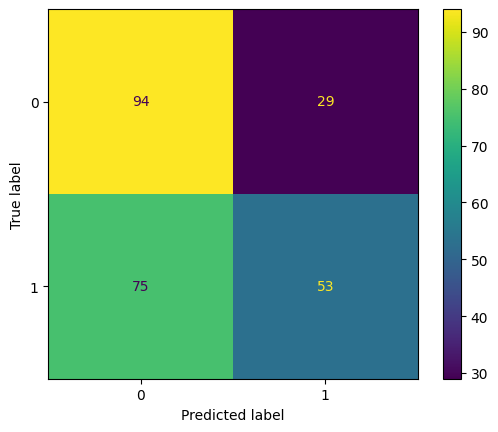

In [150]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

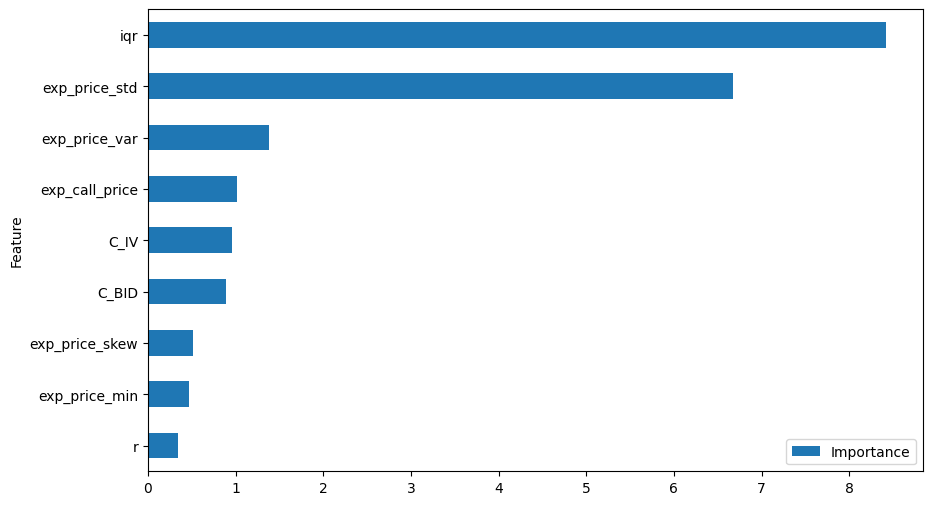

In [151]:
coefficients = best_model.named_steps["lg"].coef_[0]

feature_importance = pd.DataFrame(
    {"Feature": new_df[selected_features].columns, "Importance": np.abs(coefficients)}
)
feature_importance = feature_importance.sort_values("Importance", ascending=True)
feature_importance.plot(x="Feature", y="Importance", kind="barh", figsize=(10, 6))

### Check model

In [185]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike"], axis=1),
    ),
    axis=1,
)

In [186]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

In [187]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df[selected_features].values,
    target.values.flatten(),
    test_size=0.2,
    random_state=1968,
    shuffle=False,
)

In [188]:
lg_params = {
    "C": 1000.0,
    "max_iter": 1000,
    "penalty": "l2",
    "random_state": 1968,
    "solver": "lbfgs",
}

In [189]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        ("lg", LogisticRegression(**lg_params)),
    ]
)

In [190]:
# Fit the  model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scaler', StandardScaler()),
                ('lg',
                 LogisticRegression(C=1000.0, max_iter=1000,
                                    random_state=1968))])

In [191]:
pipe.score(X_test, y_test)

0.4701195219123506

In [192]:
predictions = pipe.predict(X_test)

In [193]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.80      0.33      0.47       177
           1       0.33      0.80      0.47        74

    accuracy                           0.47       251
   macro avg       0.57      0.57      0.47       251
weighted avg       0.66      0.47      0.47       251



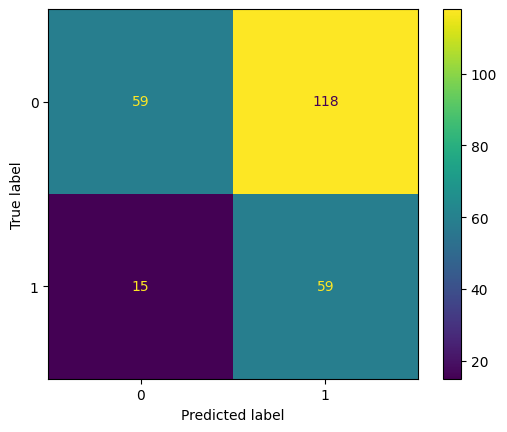

In [194]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

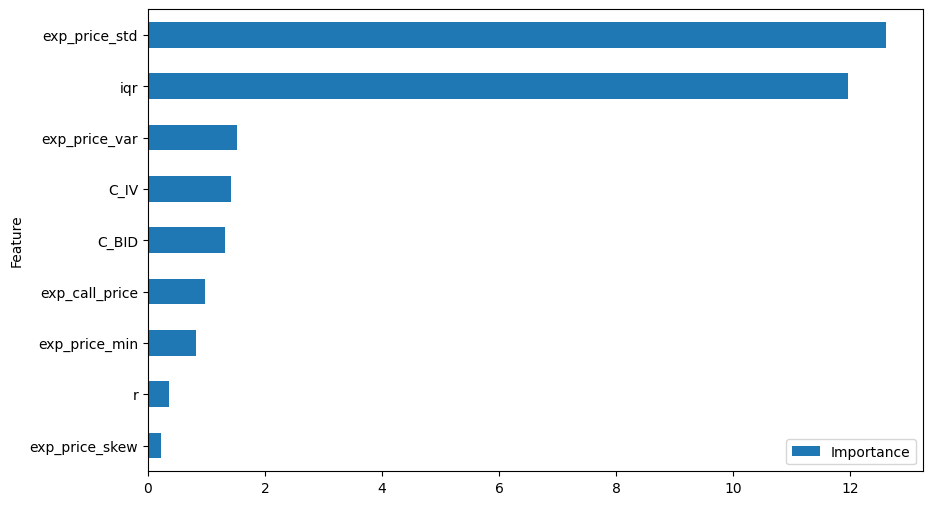

In [195]:
coefficients = pipe.named_steps["lg"].coef_[0]

feature_importance = pd.DataFrame(
    {"Feature": new_df[selected_features].columns, "Importance": np.abs(coefficients)}
)
feature_importance = feature_importance.sort_values("Importance", ascending=True)
feature_importance.plot(x="Feature", y="Importance", kind="barh", figsize=(10, 6))

## Check the model with all the features

In [163]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike"], axis=1),
    ),
    axis=1,
)

In [164]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

In [165]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df.values,
    target.values.flatten(),
    test_size=0.2,
    random_state=1968,
    shuffle=False,
)

In [175]:
lg_params = {
    "C": 10.0,
    "max_iter": 1000,
    "penalty": "l2",
    "random_state": 1968,
    "solver": "lbfgs",
}

In [176]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        ("lg", LogisticRegression(**lg_params)),
    ]
)

In [177]:
# Fit the  model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scaler', StandardScaler()),
                ('lg',
                 LogisticRegression(C=10.0, max_iter=1000, random_state=1968))])

In [178]:
pipe.score(X_test, y_test)

0.4541832669322709

In [179]:
predictions = pipe.predict(X_test)

In [180]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.78      0.32      0.45       177
           1       0.32      0.78      0.46        74

    accuracy                           0.45       251
   macro avg       0.55      0.55      0.45       251
weighted avg       0.64      0.45      0.45       251



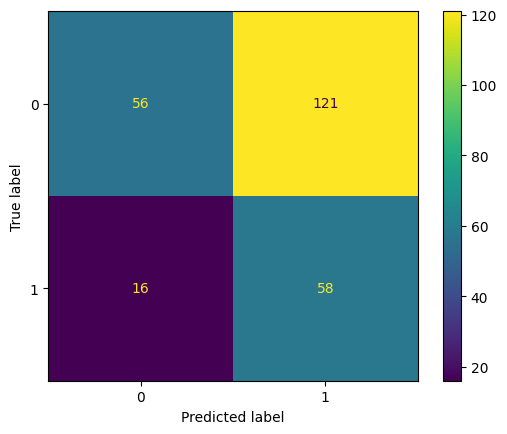

In [181]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

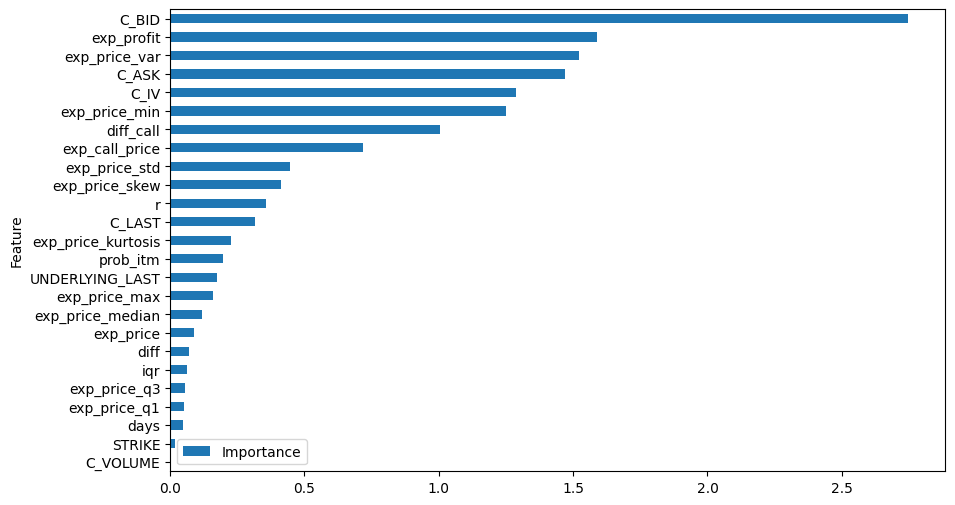

In [183]:
coefficients = pipe.named_steps["lg"].coef_[0]

feature_importance = pd.DataFrame(
    {"Feature": new_df.columns, "Importance": np.abs(coefficients)}
)
feature_importance = feature_importance.sort_values("Importance", ascending=True)
feature_importance.plot(x="Feature", y="Importance", kind="barh", figsize=(10, 6))

### Gridsearch Cross Validation

In [6]:
orig_df = ml_df[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_VOLUME",
        "diff_date",
    ]
].copy()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df.values, target.values.flatten(), test_size=0.2, random_state=1968
)

In [8]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        ("lg", LogisticRegression()),
    ]
)

In [9]:
# Penalties
penalty1 = ["l2"]
penalty2 = ["l1", "l2"]
penalty3 = ["l1", "l2", "elasticnet"]
# Number of features to consider at every split
C = np.logspace(-2, 2, 30)
# Solver
solver1 = ["lbfgs", "newton-cg", "newton-cholesky", "sag"]
solver2 = ["liblinear"]
solver3 = ["saga"]

# Create the search grid
param_grid = [
    {
        "lg__penalty": penalty1,
        "lg__C": C,
        "lg__solver": solver1,
        "lg__random_state": [1968],
        "lg__max_iter": [1000],
    },
    {
        "lg__penalty": penalty2,
        "lg__C": C,
        "lg__solver": solver2,
        "lg__random_state": [1968],
    },
    {
        "lg__penalty": penalty3,
        "lg__C": C,
        "lg__solver": solver3,
        "lg__random_state": [1968],
    },
]

In [10]:
verbose_level = 1
n_jobs = 4

In [11]:
# Grid search
lg_grid = GridSearchCV(
    estimator=pipe, param_grid=param_grid, cv=5, verbose=verbose_level, n_jobs=n_jobs
)

In [12]:
# Fit the search model
lg_grid.fit(X_train, y_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


/Users/andrea/Desktop/WQU-Course/MScFE/Capstone/wqu_capstone/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrea/Desktop/WQU-Course/MScFE/Capstone/wqu_capstone/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrea/Desktop/WQU-Course/MScFE/Capstone/wqu_capstone/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrea/Desktop/WQU-Course/MScFE/Capstone/wqu_capstone/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/andrea/Desktop/WQU-Course/MScFE/Capstone/wqu_capstone/.venv/lib/pytho

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        SimpleImputer(fill_value=0.0,
                                                      strategy='constant')),
                                       ('scaler', StandardScaler()),
                                       ('lg', LogisticRegression())]),
             n_jobs=4,
             param_grid=[{'lg__C': array([1.00000000e-02, 1.37382380e-02, 1.88739182e-02, 2.59294380e-02,
       3.56224789e-02, 4.89390092e-02, 6.72335754e-02, 9.23670857e-02,
       1.26896100e-01, 1.74332882e-01...
       4.52035366e-01, 6.21016942e-01, 8.53167852e-01, 1.17210230e+00,
       1.61026203e+00, 2.21221629e+00, 3.03919538e+00, 4.17531894e+00,
       5.73615251e+00, 7.88046282e+00, 1.08263673e+01, 1.48735211e+01,
       2.04335972e+01, 2.80721620e+01, 3.85662042e+01, 5.29831691e+01,
       7.27895384e+01, 1.00000000e+02]),
                          'lg__penalty': ['l1', 'l2', 'elasticnet'],
                          'lg__random_state': [1968], 'lg__solver': ['saga']}],
             verbose=1)

In [13]:
lg_grid.best_params_

{'lg__C': 20.433597178569418,
 'lg__penalty': 'l1',
 'lg__random_state': 1968,
 'lg__solver': 'liblinear'}

In [14]:
pd.DataFrame.from_dict(lg_grid.cv_results_).sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lg__C,param_lg__max_iter,param_lg__penalty,param_lg__random_state,param_lg__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
168,0.459995,0.103702,0.001483,0.000353,20.433597,NaN,l1,1968,liblinear,"{'lg__C': 20.433597178569418, 'lg__penalty': '...",0.577114,0.567164,0.530,0.610,0.555,0.567856,0.026308,1
178,0.518710,0.193912,0.002471,0.002280,100.0,NaN,l1,1968,liblinear,"{'lg__C': 100.0, 'lg__penalty': 'l1', 'lg__ran...",0.572139,0.572139,0.535,0.605,0.555,0.567856,0.023070,1
174,0.462066,0.128586,0.001467,0.000473,52.983169,NaN,l1,1968,liblinear,"{'lg__C': 52.98316906283707, 'lg__penalty': 'l...",0.577114,0.567164,0.535,0.610,0.545,0.566856,0.026303,3
170,0.468070,0.069669,0.002273,0.002000,28.072162,NaN,l1,1968,liblinear,"{'lg__C': 28.072162039411758, 'lg__penalty': '...",0.572139,0.562189,0.530,0.610,0.555,0.565866,0.026096,4
172,0.400850,0.111032,0.002087,0.000727,38.566204,NaN,l1,1968,liblinear,"{'lg__C': 38.56620421163472, 'lg__penalty': 'l...",0.577114,0.562189,0.535,0.605,0.550,0.565861,0.023983,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,0.003582,0.002544,0.000000,0.000000,2.212216,NaN,elasticnet,1968,saga,"{'lg__C': 2.212216291070448, 'lg__penalty': 'e...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,241
236,0.008449,0.010973,0.000000,0.000000,3.039195,NaN,elasticnet,1968,saga,"{'lg__C': 3.039195382313198, 'lg__penalty': 'e...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,241
239,0.007326,0.009820,0.000000,0.000000,4.175319,NaN,elasticnet,1968,saga,"{'lg__C': 4.175318936560401, 'lg__penalty': 'e...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,241
245,0.002819,0.000351,0.000000,0.000000,7.880463,NaN,elasticnet,1968,saga,"{'lg__C': 7.880462815669913, 'lg__penalty': 'e...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,241


In [15]:
best_model = lg_grid.best_estimator_

In [16]:
best_model.score(X_test, y_test)

0.5737051792828686

In [17]:
predictions = best_model.predict(X_test)

In [18]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.56      0.65      0.60       123
           1       0.60      0.50      0.54       128

    accuracy                           0.57       251
   macro avg       0.58      0.58      0.57       251
weighted avg       0.58      0.57      0.57       251



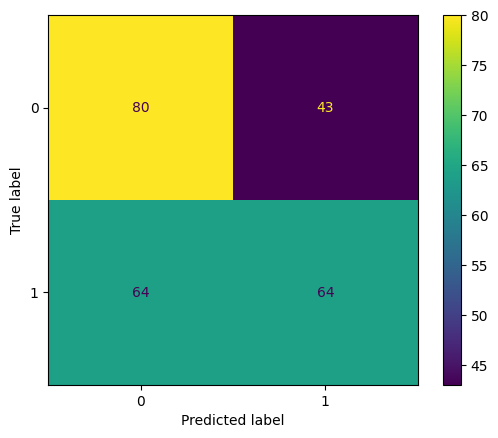

In [19]:
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

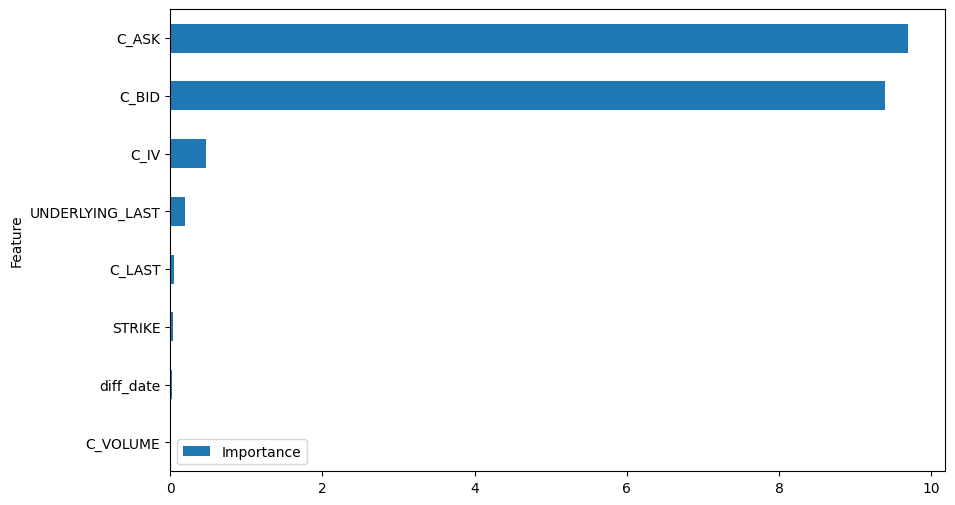

In [21]:
coefficients = best_model.named_steps["lg"].coef_[0]

feature_importance = pd.DataFrame(
    {"Feature": orig_df.columns, "Importance": np.abs(coefficients)}
)
feature_importance = feature_importance.sort_values("Importance", ascending=True)
feature_importance.plot(x="Feature", y="Importance", kind="barh", figsize=(10, 6))